# AIES ANN Project

# Salar Hosseiny Shamchi 9805884


## Part 1 with Centernet Mobilenet V2

**Note:** The dataset is ready to use, the models have been downloaded, and the necessary packages have been installed in advance.

#### Create a csv file containing dataset details

In [1]:
import glob
import xml.etree.ElementTree as ET

import pandas as pd
from tqdm import tqdm


def __list_to_csv(annotations, output_file):
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(annotations, columns=column_name)
    xml_df.to_csv(output_file, index=None)


def xml_to_csv(xml_dir, img_dir, output_file):
    """Reads all XML files, generated by labelImg, from a directory and generates a single CSV file"""
    annotations = []
    # Correction in class names
    for xml_file in tqdm(glob.glob(xml_dir + '/*.xml')):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            if member.find('name').text == 'mask_weared_incorrect':
                member.find('name').text = 'mask_worn_incorrectly'
        tree.write(xml_file)
    for xml_file in tqdm(glob.glob(xml_dir + '/*.xml')):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            value = (img_dir + root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     member[0].text,
                     int(member[5][0].text),
                     int(member[5][1].text),
                     int(member[5][2].text),
                     int(member[5][3].text))
            annotations.append(value)

    __list_to_csv(annotations, output_file)


inp_path = './ann_project/annotations'
out_file = './ann_project/dataset.csv'
im_dir = './ann_project/images/'

xml_to_csv(inp_path, im_dir, out_file)


100%|███████████████████████████████████████████████████████████████████████████████| 853/853 [00:03<00:00, 280.66it/s]


#### Create the label map file for the dataset in pbtxt format

In [2]:
import pandas as pd


def pbtxt_from_classlist(l, pbtxt_path):
    pbtxt_text = ''

    for i, c in enumerate(l):
        pbtxt_text += 'item {\n    id: ' + str(i + 1) + '\n    display_name: "' + str(c) + '"\n}\n\n'

    with open(pbtxt_path, "w+") as pbtxt_file:
        pbtxt_file.write(pbtxt_text)


def pbtxt_from_csv(csv_path, pbtxt_path):
    class_list = list(pd.read_csv(csv_path)['class'].unique())
    class_list.sort()

    pbtxt_from_classlist(class_list, pbtxt_path)


input_file = './ann_project/dataset.csv'
output_file = './ann_project/label_map.pbtxt'

pbtxt_from_csv(input_file, output_file)


#### Split data to train and test and create their associated csv file

In [5]:
import os

import pandas as pd
from sklearn.model_selection import train_test_split

input_csv = './ann_project/dataset.csv'
train_frac = 0.8
output_dir = './'

df = pd.read_csv(input_csv)

strat = df['class']

train_df, validation_df = train_test_split(df,
                                           test_size=None,
                                           train_size=train_frac)

# output files have the same name of the input file, with some extra stuff appended
new_csv_name = os.path.splitext(input_csv)[0]
train_csv_path = os.path.join(output_dir, new_csv_name + '_train.csv')
eval_csv_path = os.path.join(output_dir, new_csv_name + '_eval.csv')

train_df.to_csv(train_csv_path, index=False)
validation_df.to_csv(eval_csv_path, index=False)


#### Create tfrecord files for train and evaluation data

In [6]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import io
import os
from collections import namedtuple

import pandas as pd
import tensorflow as tf
from PIL import Image
from object_detection.utils import dataset_util
from tqdm import tqdm


def __split(df, group):
    data = namedtuple('data', ['filename', 'object'])
    gb = df.groupby(group)
    return [data(filename, gb.get_group(x)) for filename, x in zip(gb.groups.keys(), gb.groups)]


def create_tf_example(group, class_dict):
    with tf.io.gfile.GFile((group.filename), 'rb') as fid:
        encoded_png = fid.read()
    encoded_png_io = io.BytesIO(encoded_png)
    image = Image.open(encoded_png_io)
    width, height = image.size

    filename = group.filename.encode('utf8')
    image_format = b'png'
    xmins = []
    xmaxs = []
    ymins = []
    ymaxs = []
    classes_text = []
    classes = []

    for index, row in group.object.iterrows():
        if set(['xmin_rel', 'xmax_rel', 'ymin_rel', 'ymax_rel']).issubset(set(row.index)):
            xmin = row['xmin_rel']
            xmax = row['xmax_rel']
            ymin = row['ymin_rel']
            ymax = row['ymax_rel']

        elif set(['xmin', 'xmax', 'ymin', 'ymax']).issubset(set(row.index)):
            xmin = row['xmin'] / width
            xmax = row['xmax'] / width
            ymin = row['ymin'] / height
            ymax = row['ymax'] / height

        xmins.append(xmin)
        xmaxs.append(xmax)
        ymins.append(ymin)
        ymaxs.append(ymax)
        classes_text.append(str(row['class']).encode('utf8'))
        classes.append(class_dict[str(row['class'])])

    tf_example = tf.train.Example(features=tf.train.Features(
        feature={
            'image/height': dataset_util.int64_feature(height),
            'image/width': dataset_util.int64_feature(width),
            'image/filename': dataset_util.bytes_feature(filename),
            'image/source_id': dataset_util.bytes_feature(filename),
            'image/encoded': dataset_util.bytes_feature(encoded_png),
            'image/format': dataset_util.bytes_feature(image_format),
            'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
            'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
            'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
            'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
            'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
            'image/object/class/label': dataset_util.int64_list_feature(classes), }))
    return tf_example


def class_dict_from_pbtxt(pbtxt_path):
    # open file, strip \n, trim lines and keep only
    # lines beginning with id or display_name

    with open(pbtxt_path, 'r', encoding='utf-8-sig') as f:
        data = f.readlines()

    name_key = None
    if any('display_name:' in s for s in data):
        name_key = 'display_name:'
    elif any('name:' in s for s in data):
        name_key = 'name:'

    if name_key is None:
        raise ValueError(
            "label map does not have class names, provided by values with the 'display_name' or 'name' keys in the contents of the file"
        )

    data = [l.rstrip('\n').strip() for l in data if 'id:' in l or name_key in l]

    ids = [int(l.replace('id:', '')) for l in data if l.startswith('id')]
    names = [
        l.replace(name_key, '').replace('"', '').replace("'", '').strip() for l in data
        if l.startswith(name_key)]

    # join ids and display_names into a single dictionary
    class_dict = {}
    for i in range(len(ids)):
        class_dict[names[i]] = ids[i]

    return class_dict


def tfrecord_maker(csv_input, image_dir, output_path, label_map):
    class_dict = class_dict_from_pbtxt(label_map)

    writer = tf.compat.v1.python_io.TFRecordWriter(output_path)
    path = os.path.join(image_dir)
    examples = pd.read_csv(csv_input)
    grouped = __split(examples, 'filename')

    for group in tqdm(grouped, desc='groups'):
        tf_example = create_tf_example(group, class_dict)
        writer.write(tf_example.SerializeToString())

    writer.close()
    output_path = os.path.join(os.getcwd(), output_path)
    print('Successfully created the TFRecords: {}'.format(output_path))


csv_input = './ann_project/dataset_eval.csv'
image_dir = './ann_project/images/'
output_path = './ann_project/eval.tfrecord'
pbtxt_input = './ann_project/label_map.pbtxt'
tfrecord_maker(csv_input, image_dir, output_path, pbtxt_input)

csv_input = './ann_project/dataset_train.csv'
image_dir = './ann_project/images/'
output_path = './ann_project/train.tfrecord'
pbtxt_input = './ann_project/label_map.pbtxt'
tfrecord_maker(csv_input, image_dir, output_path, pbtxt_input)


groups: 100%|████████████████████████████████████████████████████████████████████████| 399/399 [00:04<00:00, 94.32it/s]


Successfully created the TFRecords: C:\Python\Jupyter\AIES\./ann_project/eval.tfrecord


groups: 100%|███████████████████████████████████████████████████████████████████████| 789/789 [00:06<00:00, 128.08it/s]


Successfully created the TFRecords: C:\Python\Jupyter\AIES\./ann_project/train.tfrecord


#### Path to model's config file, and the directory for checkpoints to be saved

In [1]:
pipeline_file = 'C:/Python/Jupyter/AIES/ann_project/models/research/deploy/centernet_mobilenetv2_fpn_od/pipeline.config'
model_dir = 'C:/Python/Jupyter/AIES/ann_project/models/research/deploy/centernet_mobilenetv2_fpn_od/checkpoint_make'

#### Training the model

In [ ]:
# The results of this cell have been evaluated in windows command prompt, in order to get real time results during
# the training process. The final results were saved in model_dir.

!python "C:/Python/Jupyter/AIES/ann_project/models/research/object_detection/model_main_tf2.py" \
        --pipeline_config_path={pipeline_file} \
        --model_dir={model_dir} \
        --alsologtostderr \
        --sample_1_of_n_eval_examples=1

#### Evaluation of the training process on tensorboard

In [38]:
%reload_ext tensorboard
%tensorboard --logdir "C:\Python\Jupyter\AIES\ann_project\models\research\deploy\centernet_mobilenetv2_fpn_od\checkpoint_make"

Reusing TensorBoard on port 6006 (pid 10416), started 1 day, 3:26:40 ago. (Use '!kill 10416' to kill it.)

## Test

#### Import necessary libraries for testing the model

In [1]:
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import label_map_util
from object_detection.utils import config_util
import matplotlib.pyplot as plt
import tensorflow as tf
from six import BytesIO
from PIL import Image
import numpy as np
%matplotlib inline
import matplotlib
import pathlib
import math
import os

#### Find last model checkpoints and sort them

In [2]:
model_name = "centernet_mobilenetv2_fpn_od"
pipeline_file = "C:/Python/ANN/models/research/deploy/" + model_name + "/pipeline.config"

filenames = list(
    pathlib.Path("C:/Python/Jupyter/AIES/ann_project/models/research/deploy/" + model_name +
                 "/checkpoint_make/").glob('*.index'))

filenames.sort()
print(filenames)

[WindowsPath('C:/Python/Jupyter/AIES/ann_project/models/research/deploy/centernet_mobilenetv2_fpn_od/checkpoint_make/ckpt-25.index'), WindowsPath('C:/Python/Jupyter/AIES/ann_project/models/research/deploy/centernet_mobilenetv2_fpn_od/checkpoint_make/ckpt-26.index'), WindowsPath('C:/Python/Jupyter/AIES/ann_project/models/research/deploy/centernet_mobilenetv2_fpn_od/checkpoint_make/ckpt-27.index'), WindowsPath('C:/Python/Jupyter/AIES/ann_project/models/research/deploy/centernet_mobilenetv2_fpn_od/checkpoint_make/ckpt-28.index'), WindowsPath('C:/Python/Jupyter/AIES/ann_project/models/research/deploy/centernet_mobilenetv2_fpn_od/checkpoint_make/ckpt-29.index'), WindowsPath('C:/Python/Jupyter/AIES/ann_project/models/research/deploy/centernet_mobilenetv2_fpn_od/checkpoint_make/ckpt-30.index'), WindowsPath('C:/Python/Jupyter/AIES/ann_project/models/research/deploy/centernet_mobilenetv2_fpn_od/checkpoint_make/ckpt-31.index')]


#### Create an object detection function from the last model checkpoint

In [3]:
# recover our saved model
pipeline_config = pipeline_file
# generally you want to put the last ckpt from training in here
model_dir = str(filenames[-1]).replace('.index', '')
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
    model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
    model=detection_model)
ckpt.restore(os.path.join(str(filenames[-1]).replace('.index', '')))


def get_model_detection_function(model):
    """Get a tf.function for detection."""

    @tf.function
    def detect_fn(image):
        """Detect objects in image."""

        image, shapes = model.preprocess(image)
        prediction_dict = model.predict(image, shapes)
        detections = model.postprocess(prediction_dict, shapes)

        return detections, prediction_dict, tf.reshape(shapes, [-1])

    return detect_fn


detect_fn = get_model_detection_function(detection_model)

#### Create a label map dictionary from the label map file

In [4]:
# map labels for inference decoding
label_map_path = './ann_project/label_map.pbtxt'
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
class_name = {}
for i in range(1, len(category_index) + 1):
    class_name[category_index[i]['id']] = category_index[i]['name']
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)
print(class_name)
print(label_map_dict)

{1: 'mask_worn_incorrectly', 2: 'with_mask', 3: 'without_mask'}
{'mask_worn_incorrectly': 1, 'with_mask': 2, 'without_mask': 3}


#### Define necessary functions for plotting detections

In [5]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size
    if path[-3:] == 'png':
        img_array = np.array(image.getdata())[:, :3]
    else:
        img_array = np.array(image.getdata())
    return img_array.reshape(im_height, im_width, 3).astype(np.uint8)


def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    thresh,
                    font_size=24,
                    figsize=(10, 10),
                    image_name=None):
    """Wrapper function to visualize detections.

    Args:
      image_np: uint8 numpy array with shape (img_height, img_width, 3)
      boxes: a numpy array of shape [N, 4]
      classes: a numpy array of shape [N]. Note that class indices are 1-based,
        and match the keys in the label map.
      scores: a numpy array of shape [N] or None.  If scores=None, then
        this function assumes that the boxes to be plotted are groundtruth
        boxes and plot all boxes as black with no classes or scores.
      category_index: a dict containing category dictionaries (each holding
        category index `id` and category name `name`) keyed by category indices.
      figsize: size for the figure.
      image_name: a name for the image file.
    """
    image_np_with_annotations = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        font_size=font_size,
        line_thickness=1,
        min_score_thresh=thresh)
    if image_name:
        plt.imsave(image_name, image_np_with_annotations)
    else:
        matplotlib.use('TkAgg')
        %matplotlib inline
        plt.figure(figsize=figsize)
        plt.imshow(image_np_with_annotations)


def crop_boxes(image_np,
               boxes,
               classes,
               scores,
               thresh):
    """Wrapper function to visualize detections by cropping and showing
    each separately.

    Args:
      image_np: uint8 numpy array with shape (img_height, img_width, 3)
      boxes: a numpy array of shape [N, 4]
      classes: a numpy array of shape [N]. Note that class indices are 1-based,
        and match the keys in the label map.
      scores: a numpy array of shape [N] or None.  If scores=None, then
        this function assumes that the boxes to be plotted are groundtruth
        boxes and plot all boxes as black with no classes or scores.
      thresh: Minimum threshold for accuracy of a detected box.
    """

    height, width = image_np.shape[:2]
    index = 0
    for a in scores:
        if a > thresh:
            index += 1
        else:
            break
    # cropped_boxes=[]
    matplotlib.use('TkAgg')
    for i in range(index):
        box = boxes[i, :]
        ymin = math.floor(box[0] * height)
        xmin = math.floor(box[1] * width)
        ymax = math.ceil(box[2] * height)
        xmax = math.ceil(box[3] * width)
        cropped_box = image_np[ymin:ymax, xmin:xmax, :]
        %matplotlib inline
        plt.imshow(cropped_box)
        plt.title(class_name[classes[i]] + ' %' + str(100 * scores[i])[:5])
        plt.show()


#### Choose an image and determine the desired threshold

In [7]:
image_path = './ann_project/images/maksssksksss822.png'
thresh = 0.35
image_np = load_image_into_numpy_array(image_path)

input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()
boxes = detections['detection_boxes'][0].numpy()
classes = (detections['detection_classes'][0].numpy() + label_id_offset).astype(int)
scores = detections['detection_scores'][0].numpy()

Instructions for updating:
Use `tf.cast` instead.


#### Visualize the results on the whole image

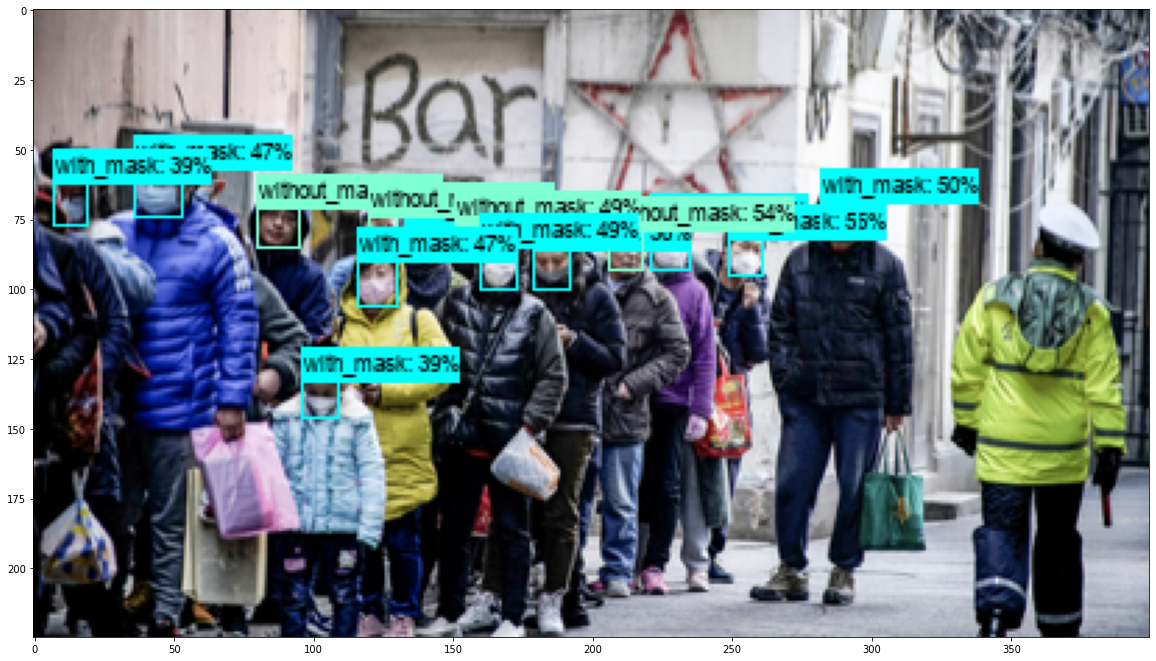

In [20]:
%matplotlib inline
plot_detections(image_np, boxes, classes, scores, category_index, thresh, font_size=8, figsize=(20, 20), image_name=None)

#### Visualize the results by cropping each detected box for better visual evaluation

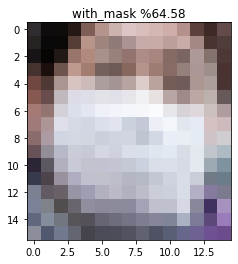

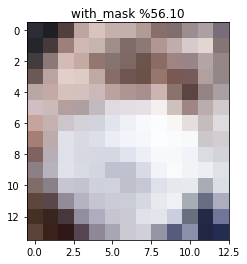

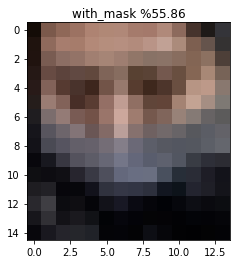

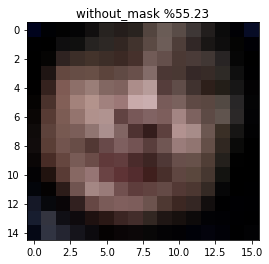

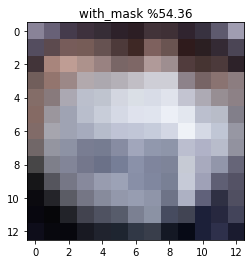

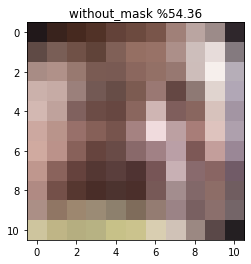

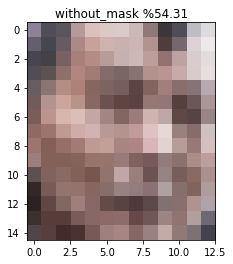

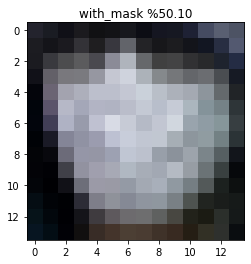

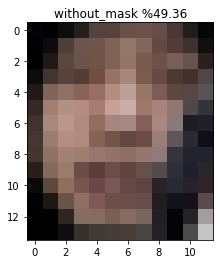

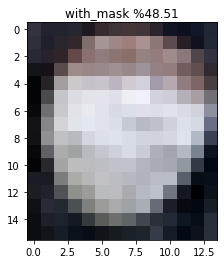

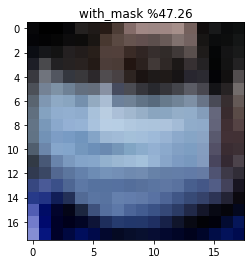

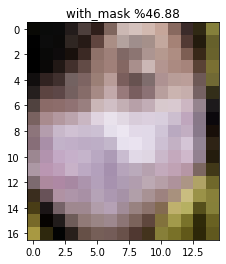

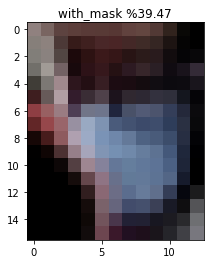

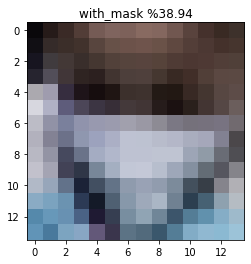

In [15]:
crop_boxes(image_np, boxes, classes, scores, thresh)

#### Choose an image and determine the desired threshold

In [8]:
image_path = './ann_project/images/maksssksksss139.png'
thresh = 0.35
image_np = load_image_into_numpy_array(image_path)

input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()
boxes = detections['detection_boxes'][0].numpy()
classes = (detections['detection_classes'][0].numpy() + label_id_offset).astype(int)
scores = detections['detection_scores'][0].numpy()

#### Visualize the results on the whole image

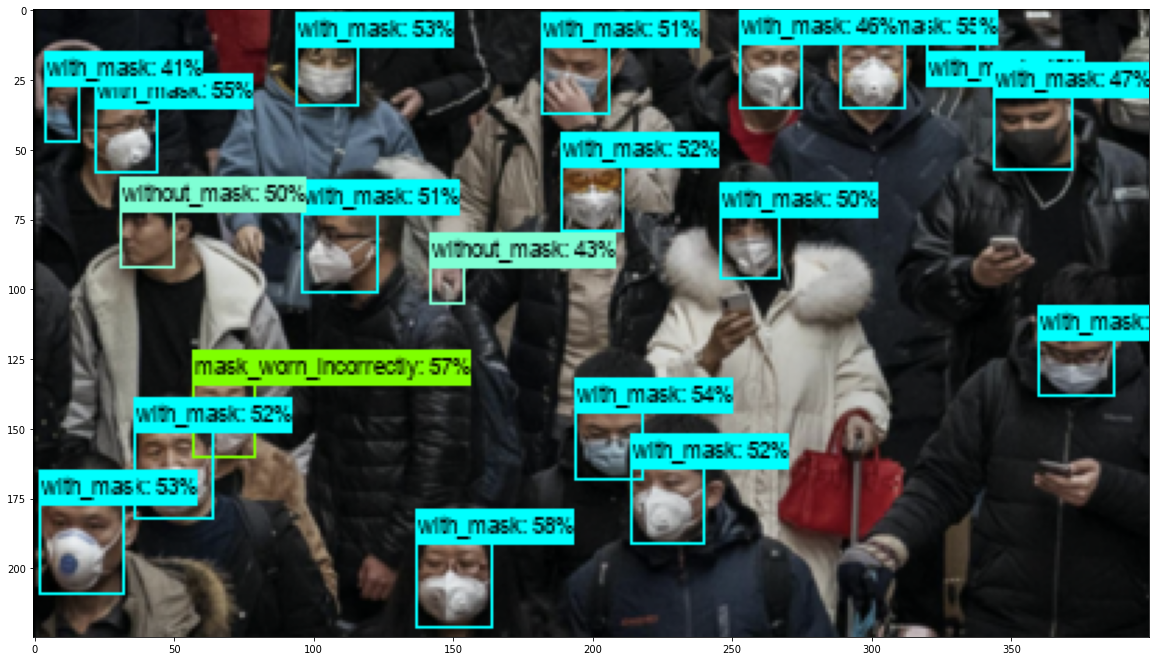

In [9]:
%matplotlib inline
plot_detections(image_np, boxes, classes, scores, category_index, thresh, font_size=8, figsize=(20, 20), image_name=None)

#### Visualize the results by cropping each detected box for better visual evaluation

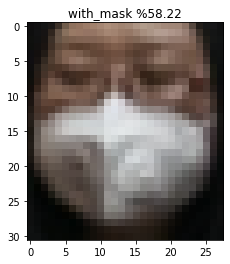

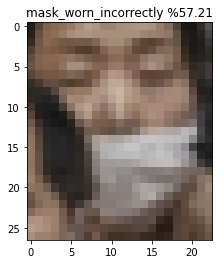

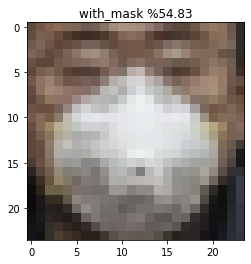

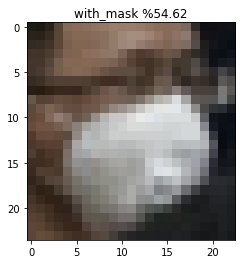

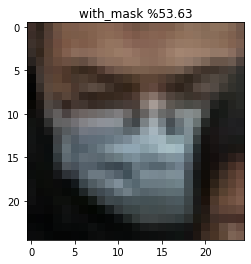

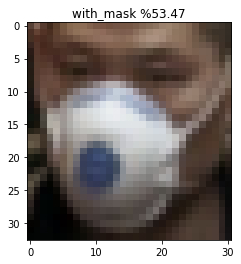

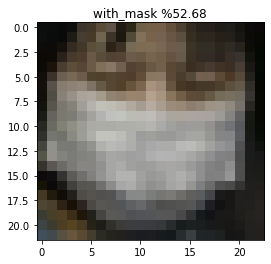

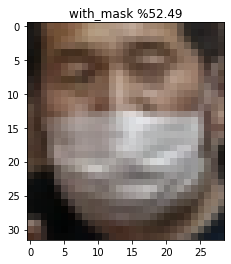

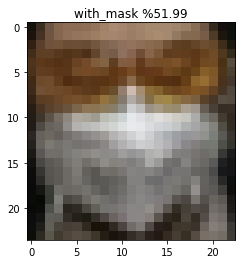

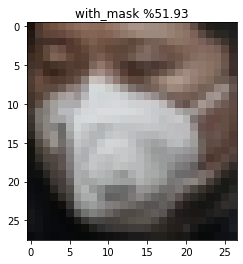

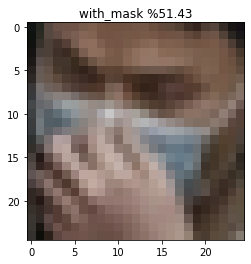

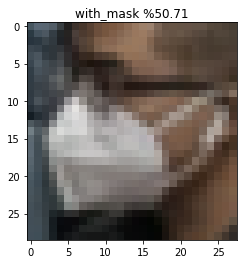

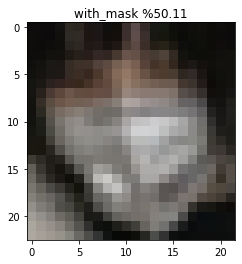

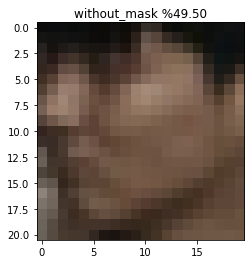

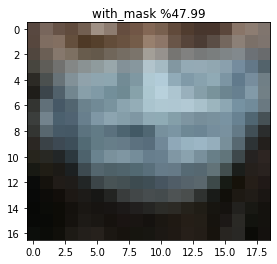

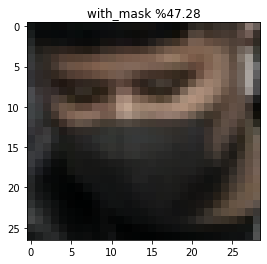

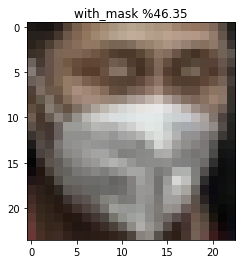

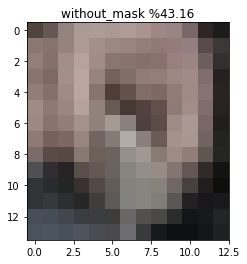

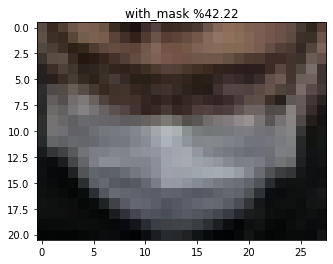

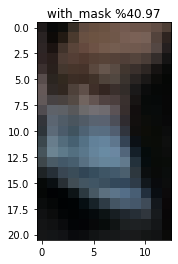

In [10]:
crop_boxes(image_np, boxes, classes, scores, thresh)

#### Choose an image and determine the desired threshold

In [11]:
image_path = './ann_project/images/maksssksksss156.png'
thresh = 0.35
image_np = load_image_into_numpy_array(image_path)

input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()
boxes = detections['detection_boxes'][0].numpy()
classes = (detections['detection_classes'][0].numpy() + label_id_offset).astype(int)
scores = detections['detection_scores'][0].numpy()

#### Visualize the results on the whole image

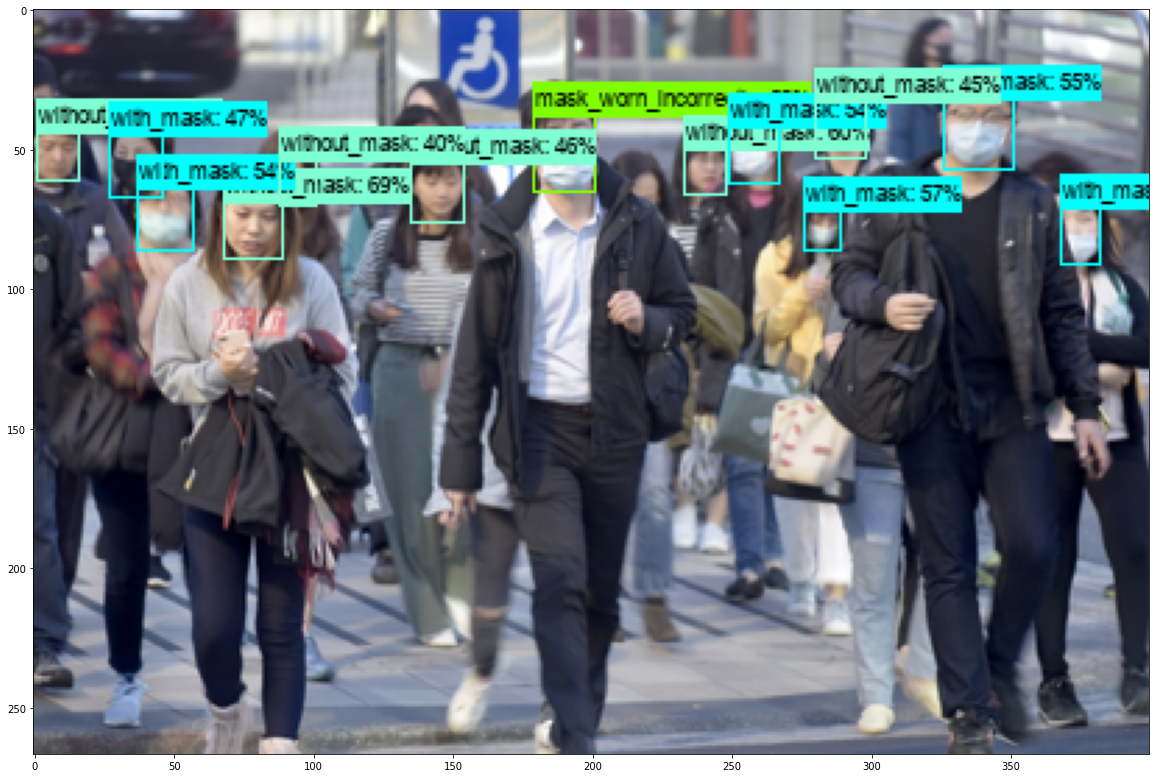

In [12]:
%matplotlib inline
plot_detections(image_np, boxes, classes, scores, category_index, thresh, font_size=8, figsize=(20, 20), image_name=None)

#### Visualize the results by cropping each detected box for better visual evaluation

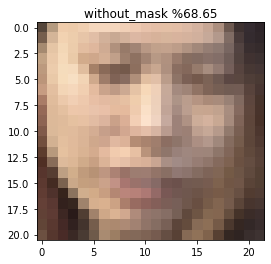

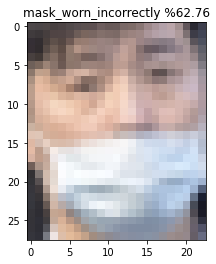

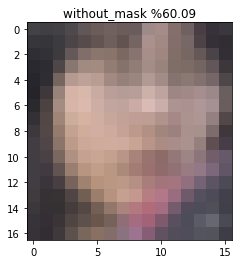

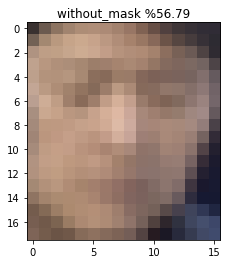

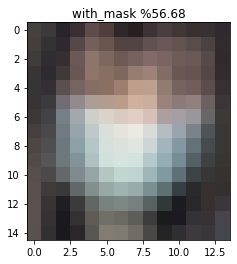

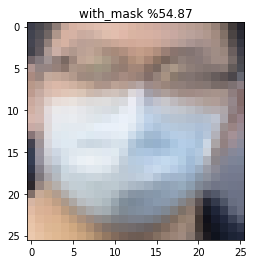

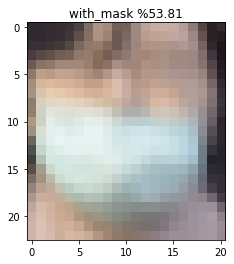

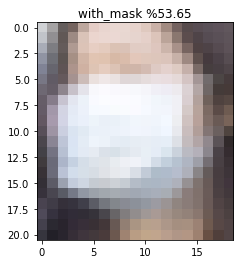

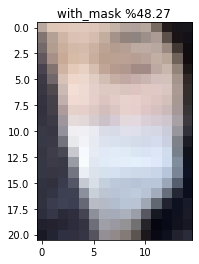

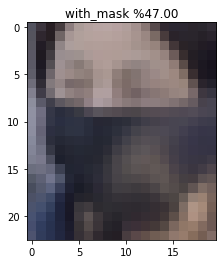

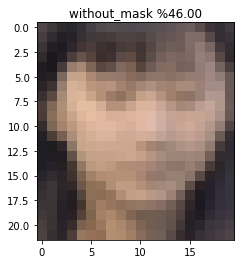

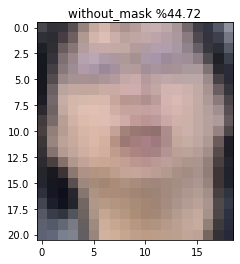

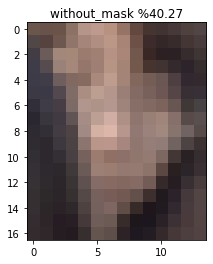

In [13]:
crop_boxes(image_np, boxes, classes, scores, thresh)

#### Choose an image and determine the desired threshold

In [7]:
image_path = './ann_project/images/maksssksksss672.png'
thresh = 0.35
image_np = load_image_into_numpy_array(image_path)

input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()
boxes = detections['detection_boxes'][0].numpy()
classes = (detections['detection_classes'][0].numpy() + label_id_offset).astype(int)
scores = detections['detection_scores'][0].numpy()

#### Visualize the results on the whole image

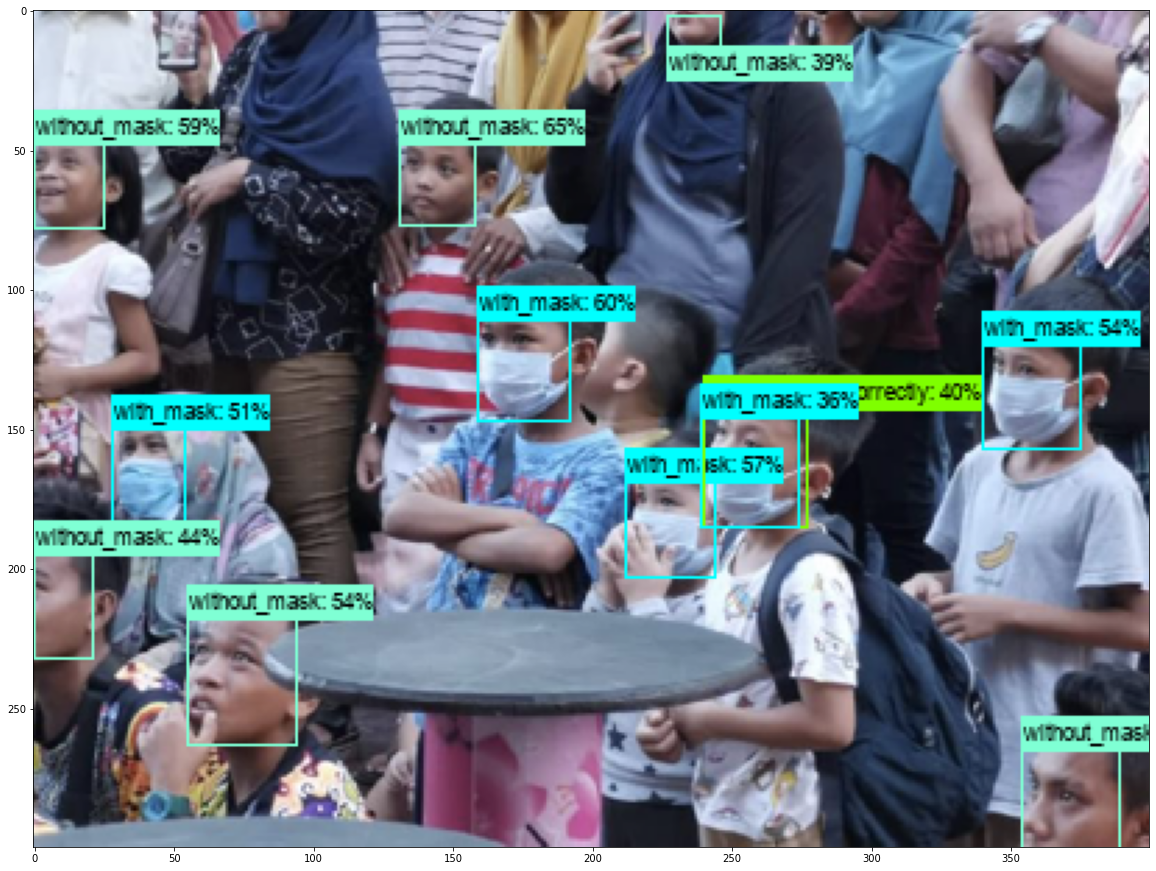

In [8]:
%matplotlib inline
plot_detections(image_np, boxes, classes, scores, category_index, thresh, font_size=8, figsize=(20, 20), image_name=None)

#### Visualize the results by cropping each detected box for better visual evaluation

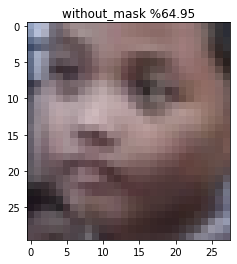

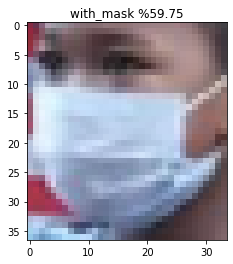

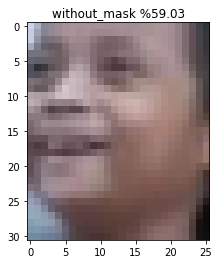

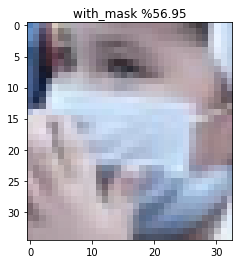

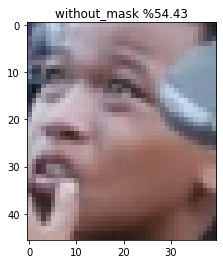

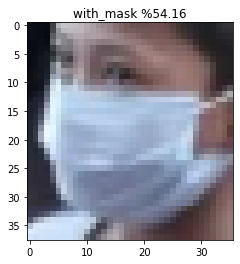

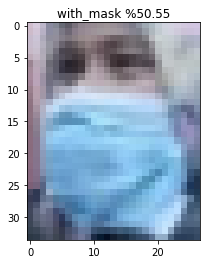

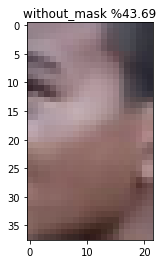

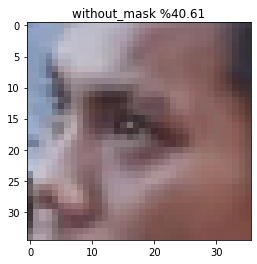

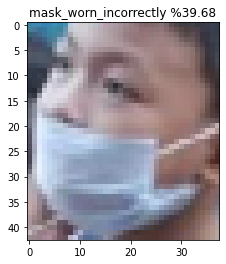

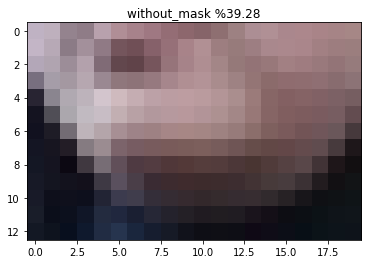

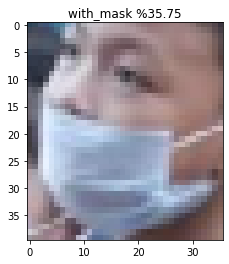

In [9]:
crop_boxes(image_np, boxes, classes, scores, thresh)